## 1. Instalação e Setup

In [1]:
# 1) Instalação das bibliotecas (execute apenas se precisar instalar)
%pip install ultralytics opencv-python matplotlib pyyaml requests oracledb --quiet

# Importações
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import glob, os, yaml
import pandas as pd

# Validação e verificação do ambiente de desenvolvimento
print("OpenCV:", cv2.__version__)
try:
    import torch
    print("PyTorch:", torch.__version__, "| CUDA disponível:", torch.cuda.is_available())
except Exception:
    pass


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


OpenCV: 4.12.0
PyTorch: 2.8.0+cpu | CUDA disponível: False


## 2. Carregar modelo pré-treinado


In [2]:
# 2) Carregar modelo pré-treinado
# Opções de pesos: 'yolov8n.pt' (nano), 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt'
MODEL_WEIGHTS = 'yolov8m.pt'  # troque conforme necessidade
model = YOLO(MODEL_WEIGHTS)
print("Modelo carregado:", MODEL_WEIGHTS)

Modelo carregado: yolov8m.pt


## 3. Selecionar VÍDEO na raiz do projeto


In [3]:
# 3) Selecionar VÍDEO na pasta 'video' dentro do projeto
ROOT = os.path.abspath(os.getcwd())  # pasta onde o notebook está
VIDEO_DIR = os.path.join(ROOT, 'video')  # pasta video dentro do projeto
EXTS = ('.mp4', '.mov', '.mkv', '.avi', '.webm', '.MP4', '.MOV', '.MKV', '.AVI', '.WEBM')

def find_first_video(video_dir):
    """Procura o primeiro vídeo na pasta especificada"""
    if not os.path.exists(video_dir):
        return None
    
    found = []
    for e in EXTS:
        found.extend(glob.glob(os.path.join(video_dir, f'*{e}')))
    found.sort()
    return found[0] if found else None

VIDEO_PATH = find_first_video(VIDEO_DIR)
if not VIDEO_PATH:
    print('Pasta do projeto:', ROOT)
    print('Pasta de vídeo procurada:', VIDEO_DIR)
    
    # Verificar se a pasta video existe
    if os.path.exists(VIDEO_DIR):
        try:
            arquivos_video = os.listdir(VIDEO_DIR)
            print('Arquivos na pasta video:', ', '.join(arquivos_video) if arquivos_video else 'Pasta vazia')
        except Exception:
            print('Erro ao listar arquivos da pasta video')
    else:
        print('❌ Pasta "video" não encontrada!')
        
    # Mostrar estrutura atual
    try:
        print('Arquivos na raiz do projeto:', ', '.join(os.listdir(ROOT)))
    except Exception:
        pass
        
    raise FileNotFoundError("Não encontrei vídeo na pasta 'video'. Verifique se o arquivo está em: " + VIDEO_DIR)

print("Vídeo selecionado:", os.path.abspath(VIDEO_PATH))

Vídeo selecionado: C:\Users\luizf\Music\SmartLocation-IOT-Sprint4\visao_computacional\video\video_motos.mp4


# 4) Utilitários


In [4]:

# Deduplicação por proximidade (mantém a maior confiança por cluster de centros)
def filtrar_motos_proximas_indices(xyxy: np.ndarray, confs: np.ndarray, distancia_minima: float = 60.0) -> np.ndarray:
    """
    Recebe arrays xyxy (N,4) e confs (N,) e retorna índices a manter.
    Estratégia gulosa: escolhe a maior confiança e suprime vizinhos cujo centro esteja a < distancia_minima.
    """
    if xyxy is None or len(xyxy) == 0:
        return np.array([], dtype=int)

    centers = np.column_stack(((xyxy[:, 0] + xyxy[:, 2]) * 0.5, (xyxy[:, 1] + xyxy[:, 3]) * 0.5))
    order = np.argsort(-confs)  # maiores confs primeiro
    keep = []
    suprimido = np.zeros(len(xyxy), dtype=bool)
    r2 = distancia_minima * distancia_minima

    for idx in order:
        if suprimido[idx]:
            continue
        keep.append(idx)
        dx = centers[:, 0] - centers[idx, 0]
        dy = centers[:, 1] - centers[idx, 1]
        suprimido |= (dx * dx + dy * dy) < r2

    return np.array(keep, dtype=int)

# Dispositivo e precisão
try:
    import torch
    DEVICE = 0 if torch.cuda.is_available() else 'cpu'
    HALF = bool(torch.cuda.is_available())
except Exception:
    DEVICE = 'cpu'
    HALF = False
print("Device:", DEVICE, "| half:", HALF)

Device: cpu | half: False


## Célula 5 — Detecção simples em VÍDEO (melhorada)



Iniciando detecção e análise das posições das motos...


Concluído. Saída MP4: C:\Users\luizf\Music\SmartLocation-IOT-Sprint4\visao_computacional\runs\track\video_motos_motos.mp4
Frames processados: 262 | Motos únicas (IDs): 25

ANÁLISE DAS POSIÇÕES DAS MOTOS DETECTADAS
Total de detecções: 838
Frames com detecções: 262
Motos únicas rastreadas: 25

Confiança:
  - Média: 0.356
  - Mínima: 0.101
  - Máxima: 0.829

Tamanho das detecções:
  - Largura média: 150.1 px
  - Altura média: 150.1 px
  - Área média: 26332.3 px²

Posições (centro):
  - X médio: 306.4
  - Y médio: 280.8
  - Range X: 89 - 422
  - Range Y: 116 - 779

ANÁLISE POR REGIÕES DA IMAGEM



🔹 Superior Direita:
   • Detecções: 563
   • Motos únicas: 11
   • Confiança média: 0.407
   • Área média: 12964.9 px²

🔹 Inferior Direita:
   • Detecções: 112
   • Motos únicas: 5
   • Confiança média: 0.260
   • Área média: 63430.9 px²

🔹 Superior Esquerda:
   • Detecções: 150
   • Motos únicas: 8
   • Confiança média: 0.248
   • Área média: 44486.9 px²

🔹 Inferior Esquerda:
   • Detecções: 13
   • Motos únicas: 1
   • Confiança média: 0.218
   • Área média: 76149.2 px²

TOP 5 POSIÇÕES MAIS DETECTADAS:
   1. Posição (~310, ~180): 61 detecções
   2. Posição (~130, ~240): 41 detecções
   3. Posição (~360, ~600): 38 detecções
   4. Posição (~300, ~210): 34 detecções
   5. Posição (~340, ~270): 31 detecções

Dados completos salvos em: C:\Users\luizf\Music\SmartLocation-IOT-Sprint4\visao_computacional\deteccoes_motos_completo.csv
Primeiras 5 detecções:
   frame  track_id   x1   y1   x2   y2  centro_x  centro_y  confianca   area  \
0      1         1  253  105  379  208       316       15

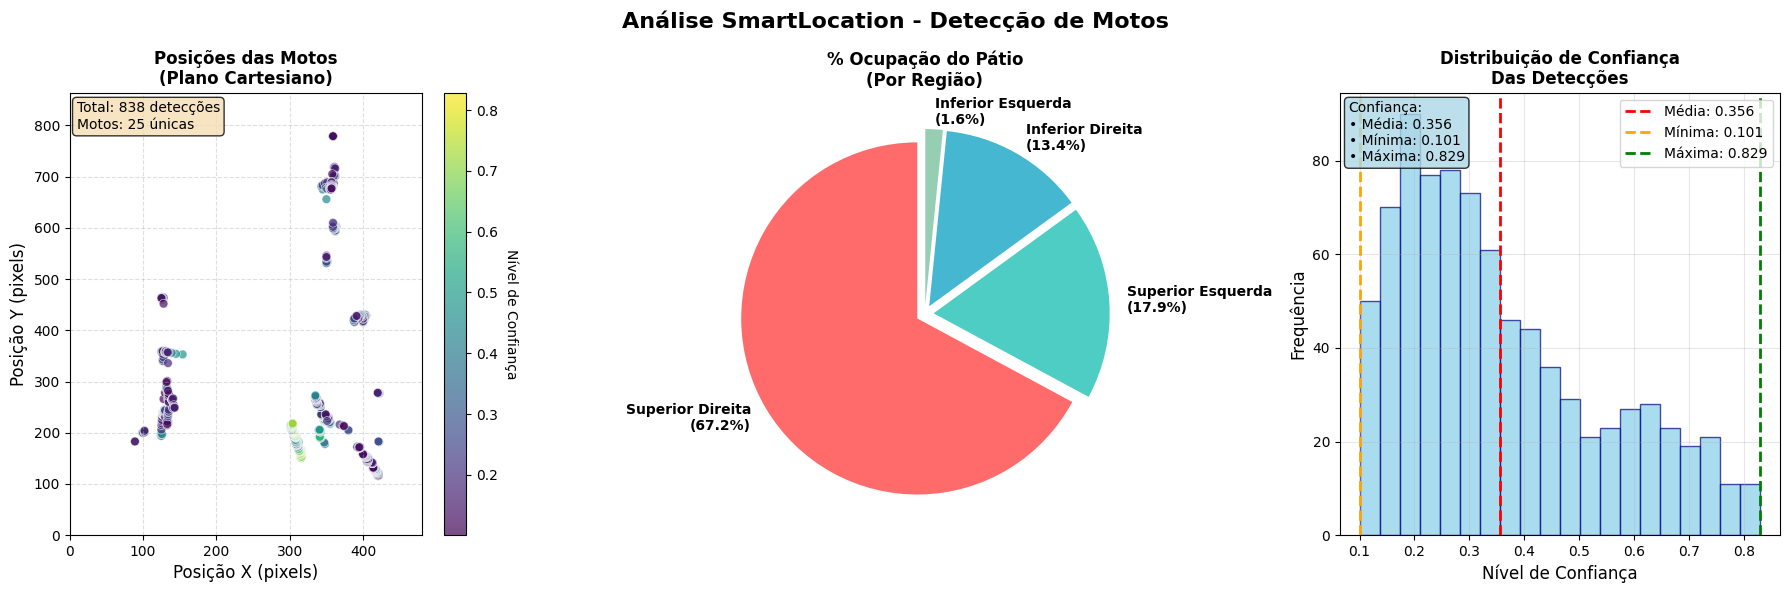


Análise completa concluída!


In [5]:
# 5) Detecção simples em VÍDEO (melhorada para alto recall) + ANÁLISE DE POSIÇÕES
CONF = 0.01          # confiança baixa para puxar objetos pequenos/longe
IOU = 0.6            # IoU um pouco mais alto para estabilidade
MAX_DET = 800        # mais detecções por frame
CLASSES = [3]        # COCO id 3 = motorcycle
IMG_SIZE = 1280      # resolução de inferência maior ajuda objetos pequenos
DEDUP_DIST = 60.0    # distância (px) entre centros para deduplicar

print("Iniciando detecção e análise das posições das motos...")
print("="*60)

# Preparar escrita MP4 com o mesmo tamanho/FPS do vídeo de entrada
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS) or 30
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

out_dir = os.path.join('runs', 'track')
os.makedirs(out_dir, exist_ok=True)
base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
output_path = os.path.join(out_dir, f"{base}_motos.mp4")
writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

seen_ids = set()     # IDs de motos já vistas (contagem única)
frames = 0
deteccoes_data = []  # Lista para coletar dados das detecções

# Gerador com ByteTrack, somente motos, nós mesmos desenhamos
results_gen = model.track(
    source=VIDEO_PATH,
    conf=CONF,
    iou=IOU,
    max_det=MAX_DET,
    classes=CLASSES,
    tracker='bytetrack.yaml',
    persist=True,
    stream=True,
    save=False,
    imgsz=IMG_SIZE,
    device=DEVICE,
    half=HALF,
    verbose=False
)

for r in results_gen:
    frames += 1
    frame = r.orig_img.copy()

    boxes = r.boxes
    if boxes is not None and len(boxes) > 0:
        # Arrays para deduplicação por proximidade
        xyxy_all = boxes.xyxy.cpu().numpy()
        confs_all = boxes.conf.cpu().numpy()

        # Garantir classe 3 (moto)
        if hasattr(boxes, 'cls') and boxes.cls is not None:
            cls = boxes.cls.cpu().numpy().astype(int)
            mask = (cls == 3)
            xyxy = xyxy_all[mask]
            confs = confs_all[mask]
            idx_map = np.nonzero(mask)[0]
        else:
            xyxy, confs = xyxy_all, confs_all
            idx_map = np.arange(len(xyxy_all))

        # Deduplicar por proximidade mantendo maior confiança
        keep_rel = filtrar_motos_proximas_indices(xyxy, confs, distancia_minima=DEDUP_DIST)
        keep_idx = idx_map[keep_rel] if keep_rel.size > 0 else np.array([], dtype=int)

        # IDs (se houver)
        ids_arr = None
        if hasattr(boxes, 'id') and boxes.id is not None:
            try:
                ids_arr = boxes.id.cpu().numpy().reshape(-1)
            except Exception:
                ids_arr = None

        color = (0, 140, 255)
        for i in keep_idx:
            x1, y1, x2, y2 = map(int, boxes.xyxy[i].cpu().numpy())
            tid = None
            if ids_arr is not None:
                try:
                    val = ids_arr[i]
                    tid = int(val) if np.isfinite(val) else None
                except Exception:
                    tid = None

            if tid is not None and tid not in seen_ids:
                seen_ids.add(tid)

            # Coletar dados da detecção para análise
            cx = int((x1 + x2) / 2)  # centro x
            cy = int((y1 + y2) / 2)  # centro y
            area = (x2 - x1) * (y2 - y1)
            conf_score = float(confs_all[i])
            
            deteccoes_data.append({
                'frame': frames,
                'track_id': tid,
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                'centro_x': cx, 'centro_y': cy,
                'confianca': conf_score,
                'area': area,
                'largura': x2 - x1,
                'altura': y2 - y1
            })

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            label = f"moto id {tid}" if tid is not None else "moto"
            cv2.putText(frame, label, (x1, max(15, y1 - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    writer.write(frame)

writer.release()
print(f"Concluído. Saída MP4: {os.path.abspath(output_path)}")
print(f"Frames processados: {frames} | Motos únicas (IDs): {len(seen_ids)}")


print("\n" + "="*60)
print("ANÁLISE DAS POSIÇÕES DAS MOTOS DETECTADAS")
print("="*60)

# Converter para DataFrame
import pandas as pd
df_motos = pd.DataFrame(deteccoes_data)

if len(df_motos) > 0:
    # === ESTATÍSTICAS GERAIS ===
    print(f"Total de detecções: {len(df_motos)}")
    print(f"Frames com detecções: {df_motos['frame'].nunique()}")
    
    if 'track_id' in df_motos and df_motos['track_id'].notna().any():
        ids_unicos = df_motos[df_motos['track_id'].notna()]['track_id'].nunique()
        print(f"Motos únicas rastreadas: {ids_unicos}")
    
    print(f"\nConfiança:")
    print(f"  - Média: {df_motos['confianca'].mean():.3f}")
    print(f"  - Mínima: {df_motos['confianca'].min():.3f}")
    print(f"  - Máxima: {df_motos['confianca'].max():.3f}")
    
    print(f"\nTamanho das detecções:")
    print(f"  - Largura média: {df_motos['largura'].mean():.1f} px")
    print(f"  - Altura média: {df_motos['altura'].mean():.1f} px")
    print(f"  - Área média: {df_motos['area'].mean():.1f} px²")
    
    print(f"\nPosições (centro):")
    print(f"  - X médio: {df_motos['centro_x'].mean():.1f}")
    print(f"  - Y médio: {df_motos['centro_y'].mean():.1f}")
    print(f"  - Range X: {df_motos['centro_x'].min():.0f} - {df_motos['centro_x'].max():.0f}")
    print(f"  - Range Y: {df_motos['centro_y'].min():.0f} - {df_motos['centro_y'].max():.0f}")

    # === ANÁLISE POR REGIÃO ===
    print("\n" + "="*50)
    print("ANÁLISE POR REGIÕES DA IMAGEM")
    print("="*50)
    
    meio_x, meio_y = w // 2, h // 2
    
    def classificar_regiao(x, y):
        if x < meio_x and y < meio_y:
            return "Superior Esquerda"
        elif x >= meio_x and y < meio_y:
            return "Superior Direita"
        elif x < meio_x and y >= meio_y:
            return "Inferior Esquerda"
        else:
            return "Inferior Direita"
    
    df_motos['regiao'] = df_motos.apply(lambda row: classificar_regiao(row['centro_x'], row['centro_y']), axis=1)
    
    for regiao in df_motos['regiao'].unique():
        dados_regiao = df_motos[df_motos['regiao'] == regiao]
        print(f"\n🔹 {regiao}:")
        print(f"   • Detecções: {len(dados_regiao)}")
        print(f"   • Motos únicas: {dados_regiao['track_id'].nunique() if dados_regiao['track_id'].notna().any() else 'N/A'}")
        print(f"   • Confiança média: {dados_regiao['confianca'].mean():.3f}")
        print(f"   • Área média: {dados_regiao['area'].mean():.1f} px²")

    # === TOP POSIÇÕES MAIS FREQUENTES ===
    print(f"\nTOP 5 POSIÇÕES MAIS DETECTADAS:")
    df_motos['pos_cluster'] = df_motos['centro_x'].round(-1).astype(int).astype(str) + "," + df_motos['centro_y'].round(-1).astype(int).astype(str)
    top_posicoes = df_motos['pos_cluster'].value_counts().head(5)
    
    for i, (pos, count) in enumerate(top_posicoes.items(), 1):
        x, y = pos.split(',')
        print(f"   {i}. Posição (~{x}, ~{y}): {count} detecções")

    # === SALVAR DADOS ===
    csv_path = os.path.join(ROOT, 'deteccoes_motos_completo.csv')
    df_motos.to_csv(csv_path, index=False)
    print(f"\nDados completos salvos em: {csv_path}")
    print(f"Primeiras 5 detecções:")
    print(df_motos.head())

    # === VISUALIZAÇÕES ===
    print(f"\nGerando visualizações...")
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Análise SmartLocation - Detecção de Motos', fontsize=16, fontweight='bold')
    
    # === GRÁFICO 1: POSIÇÃO DAS MOTOS (PLANO CARTESIANO) ===
    ax1 = axes[0]
    scatter = ax1.scatter(df_motos['centro_x'], df_motos['centro_y'], 
                         c=df_motos['confianca'], cmap='viridis', 
                         alpha=0.7, s=40, edgecolors='white', linewidths=0.5)
    
    # Configurar eixos cartesianos
    ax1.set_xlim(0, w)
    ax1.set_ylim(0, h)  # NÃO inverter Y para manter padrão cartesiano
    ax1.set_xlabel('Posição X (pixels)', fontsize=12)
    ax1.set_ylabel('Posição Y (pixels)', fontsize=12)
    ax1.set_title('Posições das Motos\n(Plano Cartesiano)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.4, linestyle='--')
    
    # Adicionar colorbar
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Nível de Confiança', rotation=270, labelpad=15)
    
    # Adicionar estatísticas no gráfico
    total_deteccoes = len(df_motos)
    motos_unicas = df_motos['track_id'].nunique() if df_motos['track_id'].notna().any() else 0
    ax1.text(0.02, 0.98, f'Total: {total_deteccoes} detecções\nMotos: {motos_unicas} únicas', 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # === GRÁFICO 2: % OCUPAÇÃO DO PÁTIO POR REGIÃO ===
    ax2 = axes[1]
    regiao_counts = df_motos['regiao'].value_counts()
    total_deteccoes = len(df_motos)
    percentuais = (regiao_counts / total_deteccoes * 100).round(1)
    
    # Cores personalizadas para as regiões
    cores_regioes = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    wedges, texts, autotexts = ax2.pie(percentuais.values, 
                                      labels=[f'{r}\n({p}%)' for r, p in zip(percentuais.index, percentuais.values)], 
                                      autopct='',
                                      startangle=90,
                                      colors=cores_regioes[:len(percentuais)],
                                      explode=[0.05] * len(percentuais))
    
    ax2.set_title('% Ocupação do Pátio\n(Por Região)', fontsize=12, fontweight='bold')
    
    # Melhorar aparência dos textos
    for text in texts:
        text.set_fontsize(10)
        text.set_fontweight('bold')
    
    # === GRÁFICO 3: DISTRIBUIÇÃO DE CONFIANÇA ===
    ax3 = axes[2]
    
    # Calcular estatísticas
    conf_media = df_motos['confianca'].mean()
    conf_min = df_motos['confianca'].min()
    conf_max = df_motos['confianca'].max()
    
    # Criar histograma
    n, bins, patches = ax3.hist(df_motos['confianca'], bins=20, alpha=0.7, 
                               color='skyblue', edgecolor='navy', linewidth=1)
    
    # Linhas verticais para estatísticas
    ax3.axvline(conf_media, color='red', linestyle='--', linewidth=2, label=f'Média: {conf_media:.3f}')
    ax3.axvline(conf_min, color='orange', linestyle='--', linewidth=2, label=f'Mínima: {conf_min:.3f}')
    ax3.axvline(conf_max, color='green', linestyle='--', linewidth=2, label=f'Máxima: {conf_max:.3f}')
    
    ax3.set_xlabel('Nível de Confiança', fontsize=12)
    ax3.set_ylabel('Frequência', fontsize=12)
    ax3.set_title('Distribuição de Confiança\nDas Detecções', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right')
    
    # Adicionar texto com estatísticas
    stats_text = f'Confiança:\n• Média: {conf_media:.3f}\n• Mínima: {conf_min:.3f}\n• Máxima: {conf_max:.3f}'
    ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    print("\nAnálise completa concluída!")
    
else:
    print("Nenhuma detecção encontrada para análise!")

In [6]:
# Salvar gráficos em runs/analise_detalhada para exibir no web
from pathlib import Path

out_dir2 = Path('runs') / 'analise_detalhada'
out_dir2.mkdir(parents=True, exist_ok=True)
img_path = out_dir2 / 'grafico_analise.png'

if 'fig' in globals():
    try:
        fig.savefig(str(img_path), dpi=150, bbox_inches='tight')
        print(f"Gráfico salvo em: {img_path.resolve()}")
    except Exception as e:
        print(f"Falha ao salvar gráfico: {e}")
else:
    print("Figura não encontrada para salvar.")

Gráfico salvo em: C:\Users\luizf\Music\SmartLocation-IOT-Sprint4\visao_computacional\runs\analise_detalhada\grafico_analise.png


## 6. Persistencia banco de dados Oracle

In [7]:
# Configurações do banco Oracle
USER = 'rm555197'
PASSWORD = '060306'
DSN = 'oracle.fiap.com.br/ORCL'

# Instalar oracledb se necessário
try:
    import oracledb
except ImportError:
    print("Instalando oracledb...")
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "oracledb"])
    import oracledb

# Garantir existência da tabela DETECCOES_MOTO (idempotente)
def garantir_tabela_deteccoes():
    ddl = (
        """
        CREATE TABLE DETECCOES_MOTO (
            ID_DETECCAO        NUMBER GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
            ID_MOTO            NUMBER,
            POSICAO_X          NUMBER,
            POSICAO_Y          NUMBER,
            CONFIANCA          NUMBER(5,3),
            HORARIO_REGISTRO   DATE DEFAULT SYSDATE
        )
        """
    )
    try:
        conn = oracledb.connect(user=USER, password=PASSWORD, dsn=DSN)
        cur = conn.cursor()
        cur.execute("SELECT COUNT(*) FROM USER_TABLES WHERE TABLE_NAME = 'DETECCOES_MOTO'")
        exists = cur.fetchone()[0] > 0
        if not exists:
            print("Criando tabela DETECCOES_MOTO...")
            cur.execute(ddl)
            conn.commit()
            print("Tabela criada com sucesso.")
        else:
            print("Tabela DETECCOES_MOTO já existe.")
        cur.close(); conn.close()
        return True
    except Exception as e:
        print(f"Erro ao garantir tabela DETECCOES_MOTO: {e}")
        return False

# Chama uma vez para garantir o schema antes de operações de limpeza/inserção
_ = garantir_tabela_deteccoes()

def limpar_tabela():
    """Remove dados duplicados da tabela"""
    try:
        conn = oracledb.connect(user=USER, password=PASSWORD, dsn=DSN)
        cursor = conn.cursor()
        
        cursor.execute("DELETE FROM DETECCOES_MOTO")
        conn.commit()
        
        cursor.close()
        conn.close()
        print("Tabela limpa para insercao")
        return True
        
    except Exception as e:
        print(f"Erro ao limpar tabela: {e}")
        return False

def processar_motos_unicas(df_motos):
    """Processa apenas 1 registro por moto unica (melhor deteccao)"""
    if df_motos.empty:
        return df_motos
    
    # Filtrar apenas motos com track_id valido
    df_validas = df_motos[df_motos['track_id'].notna() & (df_motos['track_id'] > 0)].copy()
    
    if df_validas.empty:
        print("Nenhuma moto com ID valido encontrada")
        return pd.DataFrame()
    
    # Para cada moto unica, pegar apenas a deteccao com maior confianca
    motos_unicas = df_validas.loc[df_validas.groupby('track_id')['confianca'].idxmax()]
    
    print(f"Processamento concluido:")
    print(f"- Total de deteccoes: {len(df_motos)}")
    print(f"- Deteccoes com ID valido: {len(df_validas)}")
    print(f"- Motos unicas identificadas: {len(motos_unicas)}")
    
    return motos_unicas

def salvar_no_banco(df_motos_unicas):
    """Salva apenas motos unicas no banco Oracle"""
    try:
        print("Conectando ao banco Oracle...")
        conn = oracledb.connect(user=USER, password=PASSWORD, dsn=DSN)
        cursor = conn.cursor()
        
        print(f"Inserindo {len(df_motos_unicas)} motos unicas...")
        
        for _, row in df_motos_unicas.iterrows():
            id_moto = int(row['track_id'])
            pos_x = int(row['centro_x'])
            pos_y = int(row['centro_y'])
            confianca = float(row['confianca'])
            
            cursor.execute("""
                INSERT INTO DETECCOES_MOTO 
                (ID_MOTO, POSICAO_X, POSICAO_Y, CONFIANCA) 
                VALUES (:1, :2, :3, :4)
            """, (id_moto, pos_x, pos_y, confianca))
        
        conn.commit()
        print("Motos unicas salvas com sucesso!")
        
        cursor.close()
        conn.close()
        return True
        
    except Exception as e:
        print(f"Erro ao salvar: {e}")
        return False

def listar_motos_cadastradas():
    """Lista motos cadastradas no banco"""
    try:
        conn = oracledb.connect(user=USER, password=PASSWORD, dsn=DSN)
        cursor = conn.cursor()
        
        cursor.execute("""
            SELECT ID_MOTO, POSICAO_X, POSICAO_Y, CONFIANCA
            FROM DETECCOES_MOTO 
            ORDER BY ID_MOTO
        """)
        
        motos = cursor.fetchall()
        
        print("MOTOS UNICAS CADASTRADAS:")
        print("-" * 40)
        for moto in motos:
            print(f"ID Moto: {moto[0]} | X: {moto[1]} | Y: {moto[2]} | Conf: {moto[3]:.3f}")
        
        print(f"\nTotal de motos unicas cadastradas: {len(motos)}")
            
        cursor.close()
        conn.close()
        
    except Exception as e:
        print(f"Erro ao listar motos: {e}")

# EXECUTAR SALVAMENTO DE MOTOS UNICAS
if 'df_motos' in locals() and len(df_motos) > 0:
    # Remover coluna frame se existir
    if 'frame' in df_motos.columns:
        df_motos = df_motos.drop(columns=['frame'])
    
    print(f"Preparando processamento de motos unicas...")
    
    # Processar para obter apenas motos unicas
    df_motos_unicas = processar_motos_unicas(df_motos)
    
    if not df_motos_unicas.empty:
        # Limpar tabela e salvar motos unicas
        if limpar_tabela():
            if salvar_no_banco(df_motos_unicas):
                print("\nMotos unicas cadastradas no banco:")
                listar_motos_cadastradas()
    else:
        print("Nenhuma moto unica para salvar!")
    
else:
    print("Execute primeiro a Cell 5 para gerar os dados!")

Tabela DETECCOES_MOTO já existe.
Preparando processamento de motos unicas...
Processamento concluido:
- Total de deteccoes: 838
- Deteccoes com ID valido: 838
- Motos unicas identificadas: 25
Tabela limpa para insercao
Conectando ao banco Oracle...


Inserindo 25 motos unicas...
Motos unicas salvas com sucesso!

Motos unicas cadastradas no banco:


MOTOS UNICAS CADASTRADAS:
----------------------------------------
ID Moto: 1 | X: 304 | Y: 205 | Conf: 0.829
ID Moto: 2 | X: 350 | Y: 656 | Conf: 0.440
ID Moto: 3 | X: 89 | Y: 183 | Conf: 0.353
ID Moto: 8 | X: 353 | Y: 228 | Conf: 0.430
ID Moto: 13 | X: 126 | Y: 465 | Conf: 0.310
ID Moto: 15 | X: 398 | Y: 430 | Conf: 0.368
ID Moto: 16 | X: 344 | Y: 233 | Conf: 0.675
ID Moto: 17 | X: 126 | Y: 197 | Conf: 0.457
ID Moto: 20 | X: 416 | Y: 127 | Conf: 0.532
ID Moto: 21 | X: 422 | Y: 182 | Conf: 0.506
ID Moto: 24 | X: 125 | Y: 359 | Conf: 0.307
ID Moto: 29 | X: 154 | Y: 353 | Conf: 0.479
ID Moto: 30 | X: 361 | Y: 600 | Conf: 0.321
ID Moto: 34 | X: 380 | Y: 205 | Conf: 0.358
ID Moto: 35 | X: 422 | Y: 277 | Conf: 0.401
ID Moto: 38 | X: 132 | Y: 286 | Conf: 0.455
ID Moto: 43 | X: 102 | Y: 203 | Conf: 0.368
ID Moto: 50 | X: 358 | Y: 678 | Conf: 0.417
ID Moto: 52 | X: 359 | Y: 779 | Conf: 0.362
ID Moto: 53 | X: 134 | Y: 222 | Conf: 0.317
ID Moto: 76 | X: 335 | Y: 273 | Conf: 0.491
ID Moto: 79 | 

## 6.1 Executar Inserção no Banco Oracle

In [8]:
# 6.2 Script SIMPLES - Testar dados no banco Oracle

def teste_tabela():
    """Verifica se tabela existe"""
    try:
        conn = oracledb.connect(user=USER, password=PASSWORD, dsn=DSN)
        cursor = conn.cursor()
        
        cursor.execute("SELECT COUNT(*) FROM USER_TABLES WHERE TABLE_NAME = 'DETECCOES_MOTO'")
        existe = cursor.fetchone()[0]
        
        if existe > 0:
            print("Tabela DETECCOES_MOTO existe!")
        else:
            print("Tabela NAO existe!")
            
        cursor.close()
        conn.close()
        return existe > 0
        
    except Exception as e:
        print(f"Erro: {e}")
        return False

def listar_dados():
    """Lista dados da tabela"""
    try:
        conn = oracledb.connect(user=USER, password=PASSWORD, dsn=DSN)
        cursor = conn.cursor()
        
        # Contar total
        cursor.execute("SELECT COUNT(*) FROM DETECCOES_MOTO")
        total = cursor.fetchone()[0]
        print(f"Total de registros: {total}")
        
        if total > 0:
            # Mostrar IDs únicos das motos
            cursor.execute("""
                SELECT DISTINCT ID_MOTO
                FROM DETECCOES_MOTO 
                WHERE ID_MOTO > 0
                ORDER BY ID_MOTO
            """)
            
            ids_motos = [row[0] for row in cursor.fetchall()]
            print(f"IDs das motos cadastradas: {ids_motos}")
        else:
            print("Tabela vazia!")
            
        cursor.close()
        conn.close()
        
    except Exception as e:
        print(f"Erro: {e}")

# EXECUTAR TESTES
print("TESTE SIMPLES DO BANCO")
print("="*30)

if teste_tabela():
    print()
    listar_dados()

print("\nTeste concluido!")

TESTE SIMPLES DO BANCO
Tabela DETECCOES_MOTO existe!


Total de registros: 25
IDs das motos cadastradas: [1, 2, 3, 8, 13, 15, 16, 17, 20, 21, 24, 29, 30, 34, 35, 38, 43, 50, 52, 53, 76, 79, 80, 88, 92]

Teste concluido!
